In [29]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Activation, Dropout, Flatten, Dense
import json
import random as rn
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101, ResNet152


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_dir='./data'
num_classes = 13
batch_size = 32
image_size = (224, 224)
inputs = tf.keras.Input(shape=(224, 224, 3))

In [4]:

def generate_datasets(data_dir, validation_split=0.2):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=42,
        labels="inferred",
        label_mode="categorical",
        image_size=image_size,
        batch_size=batch_size)
    return train_ds, val_ds

In [5]:
def augment_dataset(train_dataset, validation_dataset):
    def augment_images(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        # image = tf.image.random_brightness(image, 0.2)
        # image = tf.image.random_contrast(image, 0.5, 1.5)
        image = tf.image.random_saturation(image, 1.2, 1.8) # make colors more vibrant
        image = tf.image.random_hue(image, 0.5)
        # image = tf.image.random_resized_crop(image, size, scale=(0.08, 1.0), ratio=(0.75, 1.33), seed=None, name=None)
        return image, label

    aug_train_ds = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    aug_val_ds = validation_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)

    image, _ = next(iter(aug_train_ds.take(1)))
    # peek
    plt.imshow(image[1])
    plt.show()
    
    return aug_train_ds, aug_val_ds

In [76]:
# define model architecture
# def create_resnet_v1():
#     model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#     for layer in model.layers[:-1]:
#         layer.trainable = False
#     x = model.layers[-2].output
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=model.input, outputs=predictions, name='resnetv1')

# def create_resnet_v2():
#     model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#     for layer in model.layers[:-1]:
#         layer.trainable = False
#     x = model.layers[-2].output
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=model.input, outputs=predictions, name='resnetv2')

# def create_resnet_v3():
#     model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#     for layer in model.layers[:-1]:
#         layer.trainable = False
#     x = model.layers[-2].output
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=model.input, outputs=predictions, name='resnetv3')

# def create_resnet_v4():
#     model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#     for layer in model.layers[:-1]:
#         layer.trainable = False
#     x = model.layers[-2].output
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=model.input, outputs=predictions, name='resnetv4')


def create_resnet_v1():
    model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    for layer in model.layers[:-1]:
        layer.trainable = False
    x = model.layers[-2].output
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=model.input, outputs=predictions, name='resnet50')

def create_resnet101():
    model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    for layer in model.layers[:-1]:
        layer.trainable = False
    x = model.layers[-2].output
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=model.input, outputs=predictions, name='resnet101')

def create_resnet152():
    model = ResNet152(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    for layer in model.layers[:-1]:
        layer.trainable = False
    x = model.layers[-2].output
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=model.input, outputs=predictions, name='resnet152')

# def create_nasnetlarge():
#     model = tf.keras.applications.NASNetLarge(weights='imagenet',
#                                             include_top=False,
#                                             input_shape=(224,224,3))
#     # Freeze the pre-trained weights
#     for layer in model.layers:
#         layer.trainable = False
#     model.layers[-1].outbound_nodes = []
#     model.outputs = [model.layers[-1].output]
#     predictions = Dense(num_classes, activation='softmax')(model.layers[-1].output)
#     model = Model(inputs=model.inputs, outputs=predictions)



In [79]:
# Training
def train_model(model, train_ds, val_ds, optimizer, epochs, aug):
    if aug is True:
        name = f'{model.name}_aug_{optimizer}'
    else:
        name = f'{model.name}_{optimizer}'
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') > 0.90:
                self.model.save("./archive/{}/{}_{}.h5".format(name, name, epoch))
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
                print("\nReached 99% accuracy so cancelling training!")
                self.model.stop_training = True
                
    callback = myCallback()
    

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        'MeanSquaredError',
                        'AUC',])

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[callback],
        verbose=1)

    with open(f'./archive/{name}-history.json', 'w') as f:
        json.dump(history.history, f)


def train_models(models, train_ds, val_ds, optimizer, epochs, aug):
    for model in models:
        train_model(model(), train_ds, val_ds, optimizer, epochs, aug)

Found 2643 files belonging to 13 classes.
Using 2115 files for training.
Found 2643 files belonging to 13 classes.
Using 528 files for validation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


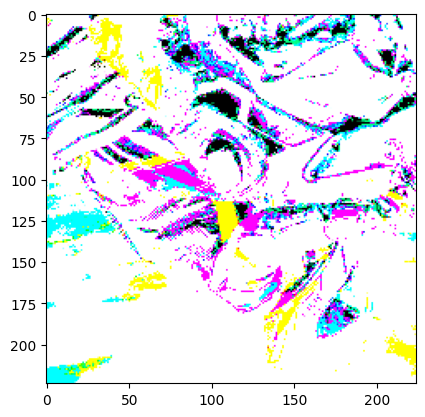

Epoch 1/100
35/67 [==============>...............] - ETA: 3s - loss: 2.5212 - accuracy: 0.3277 - mean_squared_error: 0.0661 - auc: 0.7430

KeyboardInterrupt: 

In [82]:
data_dir='./tmp'
t_ds, v_ds = generate_datasets(data_dir)
train_ds, val_ds = augment_dataset(t_ds, v_ds)

models = {
    # "resnetv2": create_resnet_v2,    
    # "resnetv3": create_resnet_v3,    
    # "resnetv4": create_resnet_v4
    # "nasnetlargev1": create_nasnetlarge,
    "resnet101": create_resnet101,
    "resnet152": create_resnet152,
    "resnetv1": create_resnet_v1,
    }



# train_models(models.values(), train_ds, val_ds, 'adam', epochs=100, aug=True)

train_models(models.values(), t_ds, v_ds, 'adam', epochs=100, aug=False)



# train_models(models.values(), train_ds, val_ds, 'nadam')
# train_models(models.values(), train_ds, val_ds, 'adadelta')